# Fashion-MNIST with Keras - - - Serap Aydogdu 


# 1. Analyzing Data<br/>
* **Import Libraries** <br/><br/>
* **Read Data** <br/><br/>
* **Explore Data** <br/><br/>
* **Visualize Data** <br/><br/>

### a. Import Libraries

In [37]:
# Ignore warnings :
import warnings
warnings.filterwarnings('ignore')

# Handle table-like data and matrices :
from keras.utils import to_categorical
import numpy as np
import pandas as pd

# Preprocessing :
from sklearn.preprocessing import MinMaxScaler , StandardScaler, Imputer, LabelEncoder
from sklearn import preprocessing

# Regression
from sklearn.metrics import mean_squared_log_error,mean_squared_error, r2_score,mean_absolute_error 

# Classification
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score  

# Modelling Helpers :
from sklearn.preprocessing import Imputer , Normalizer , scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV , KFold , cross_val_score

# Deep Learning Libraries
from keras.models import Sequential, load_model  # Sequencial ile weigthleri initialize ediyoruz.
from keras.layers import Dense, Dropout, Flatten  # Dense ile layerlarımızı construct ediyoruz.
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler
from keras.utils import to_categorical

# Visualisation
import matplotlib as mpl
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
import missingno as msno

# Configure visualisations
%matplotlib inline
mpl.style.use( 'ggplot' )
plt.style.use('fivethirtyeight')
sns.set(context="notebook", palette="dark", style = 'whitegrid' , color_codes=True)

### b. Read Data

In [38]:
data_train = pd.read_csv('fashion-mnist_train.csv')
data_test = pd.read_csv('fashion-mnist_test.csv')

df_train = data_train.copy()
df_test = data_test.copy()

In [39]:
df_train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


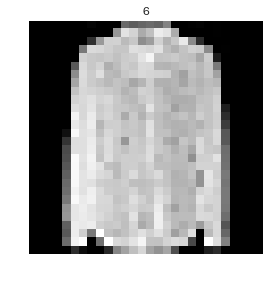

In [40]:
img = df_train.drop('label', axis=1).iloc[2].as_matrix()
img = img.reshape(28,28)
plt.imshow(img,cmap="gray")
plt.title(df_train.iloc[2,0])
plt.axis("off")
plt.show()

### c. Explore Data

In [41]:
print('Train: ', df_train.shape)
print('Test: ', df_test.shape)

Train:  (60000, 785)
Test:  (10000, 785)


- **So, there are 60,000 Training Samples and 10,000 Test Samples.**
- **Each example is a 28x28 grayscale image, associated with a label from 10 classes.**
        - Each pixel has a single pixel-value associated with it, indicating the lightness or    darkness of that pixel, 
        - with higher numbers meaning darker.
        - This pixel-value is an integer between 0 and 255, inclusive.

- **The first column of the Training Samples consists of Class Labels and represents the article of Clothing.**

In [42]:
df_train["label"].unique()

array([2, 9, 6, 0, 3, 4, 5, 8, 7, 1], dtype=int64)

**Labels :**

0 - T-shirt/top <br/>
1 - Trouser <br/>
2 - Pullover <br/>
3 - Dress <br/>
4 - Coat <br/>
5 - Sandals <br/>
6 - Shirt <br/>
7 - Sneaker <br/>
8 - Bag <br/>
9 - Ankle Boots <br/>

In [43]:
## Distribution of Labels
df_train["label"].value_counts()

9    6000
8    6000
7    6000
6    6000
5    6000
4    6000
3    6000
2    6000
1    6000
0    6000
Name: label, dtype: int64

In [44]:
## Distribution of Labels
df_test["label"].value_counts()

7    1000
6    1000
5    1000
4    1000
3    1000
2    1000
9    1000
1    1000
8    1000
0    1000
Name: label, dtype: int64

Each class distributed equally

In [45]:
# Is there any null values or not ?
print(df_train.isnull().values.any())
print(df_test.isnull().values.any())

False
False


There is no any null values

### d. Visualize Data

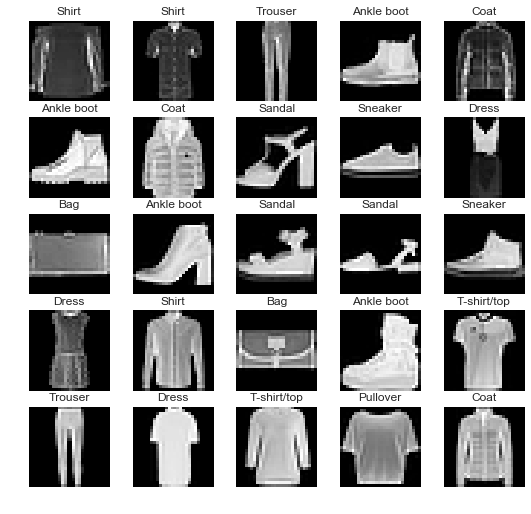

In [46]:
# Mapping Classes
clothing = {0 : 'T-shirt/top',
            1 : 'Trouser',
            2 : 'Pullover',
            3 : 'Dress',
            4 : 'Coat',
            5 : 'Sandal',
            6 : 'Shirt',
            7 : 'Sneaker',
            8 : 'Bag',
            9 : 'Ankle boot'}


fig, axes = plt.subplots(5, 5, figsize = (8,8))
for row in axes:
    for axe in row:
        index = np.random.randint(60000)
        img = df_train.drop('label', axis=1).values[index].reshape(28,28)
        cloths = df_train['label'][index]
        axe.imshow(img, cmap='gray')
        axe.set_title(clothing[cloths])
        axe.set_axis_off()


# 2. Data Preparation

* **Normalization**
    * Normalization makes training less sensitive to the scale of features, so we can better solve for coefficients and weights.
    * If we perform normalization, CNN works faster.
    * They need to be scaled down to [0,1] in order for Optimization Algorithms to work much faster. Here, we acheive Zero Mean       and Unit Variance. <br/><br/>

* **Reshape**
    * Train and test images (28 x 28)
    * We reshape all data to 28x28x1 3D matrices.
    * Keras needs an extra dimension in the end which correspond to channels. Our images are gray scaled so it use only one channel. <br/><br/>
    
* **Label Encoding**
    * Encode labels to one hot vectors
        * 2 => [0,0,1,0,0,0,0,0,0,0]
        * 4 => [0,0,0,0,1,0,0,0,0,0]
        
* **Train-Validation**
    * We split train data as train and validation data set before testing the result of training with test data.

### a. Normalization, Reshaping and Label Encoding

In [47]:
# put labels into y_train variable
y_train = df_train["label"]
X_train = df_train.drop(labels = ["label"],axis = 1) 

# put labels into y_test variable
y_test = df_test["label"]
X_test = df_test.drop(labels = ["label"],axis = 1) 

In [48]:
y_train.shape

(60000,)

In [49]:
y_test.shape

(10000,)

In [50]:
# Normalize the data
X_train = X_train / 255.0
X_test = X_test / 255.0
print("x_train shape: ",X_train.shape)
print("X_test shape: ",X_test.shape)

x_train shape:  (60000, 784)
X_test shape:  (10000, 784)


In [51]:
# Reshape
X_train = X_train.values.reshape(-1,28,28,1)
test = X_test.values.reshape(-1,28,28,1)
print("x_train shape: ",X_train.shape)
print("test shape: ",test.shape)

x_train shape:  (60000, 28, 28, 1)
test shape:  (10000, 28, 28, 1)


In [52]:
# Label Encoding (one-hot-encoding)
from keras.utils.np_utils import to_categorical 
y_train = to_categorical(y_train, num_classes = 10)
y_test = to_categorical(y_test, num_classes = 10)

In [53]:
y_test.shape

(10000, 10)

### b. Train - Validation Split

In [54]:
# Split the train and the validation set for the fitting
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state=42)
print("X_train shape",X_train.shape)
print("X_val shape",X_val.shape)
print("y_train shape",y_train.shape)
print("y_val shape",y_val.shape)

X_train shape (48000, 28, 28, 1)
X_val shape (12000, 28, 28, 1)
y_train shape (48000, 10)
y_val shape (12000, 10)


# 3. Implementing with Keras
Convolutional Neural Network (CNN) is used for image classification, object detection. 

The main structural feature of CNN is that all the neurons are connected to each other. So, When it comes to images, there seems to be little correlation or relation between two individual pixels unless they are close to each other. This leads to the idea of Convolutional Layers and Pooling Layers.

### a. Create Model
* conv => max pool => dropout => conv => max pool => dropout=> conv => max pool => dropout => fully connected (2 layer)
* Dropout: Dropout is a technique where randomly selected neurons are ignored during training for preventting to overfitting. The remaining Neurons learn more features and this reduces the dependency on any one Neuron.

In [55]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization

In [56]:
# initial neural network structure. Sequential is a structure that will added layers after.
model = Sequential() 
# Bu NN yapısına layerlarımızı eklememiz gerekiyor.
num_classes = 10
# Convolution layer
# Pooling layer
# Flatten layer
# Neural Network hidden layers


# Öncelikle bir convolution operasyonu için layer olusturualım. Buna 8 tane feature detect eden filtre uygulayalım.
# same padding uyguluyoruz böylece input matristen önemli verileri kaybetmeyeden aynı size convolution matrisler olusmus olacak.
# activation: relu fonksiyonu. activasyon fonksiyonum : relu olsun. Relu outputu 0 dan kücükse 0 büyükse o degeri alsın diyoruz. (0,z) arasında range eder. Oldukca güclü bir aktivasyon fonksiyonudur sigmoid ve tanh göre.
# kernel_initializer ise weight ve bias için initial degerleri belirledigimiz parametre buda normal dagılan rastgele degerleri içersin baslangıcta.
model.add(Conv2D(32, kernel_size=(3, 3),
                 padding = 'Same',                  
                 activation='relu',
                 kernel_initializer='he_normal',
                 input_shape=(28,28,1)))
# (2*2) lik bir matris ile sub sampling yapıyor. Detaylardan cıakrak genelleştirme yapıyor. Overfit engellemek için bu adım.
model.add(MaxPooling2D(pool_size=(2, 2)))
# 4 te 1 hidden unitleri kapatıyorum. Buda overfit engellemek için.
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', padding = 'Same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), activation='relu', padding = 'Same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))
# fully connected
model.add(Flatten())
# Bir hidden layer ekliyorum. 
model.add(Dense(128, activation='relu')) 
model.add(Dropout(0.3))
# Bir de output layer ekliyorum. softmax, multi classlar için kullanılıyor.
model.add(Dense(num_classes, activation='softmax'))


### b. Define Optimizer

In [57]:
# Optimizer ise backward propagation için kullanacagım method. Adam optimizer en etkili optimizasyon fonksiyonlarından biri NN de. 
# Optimizasyonda min. noktaya giderken ilerleyişimizi hızlandırıp, yavaslatan bir ayar bu.
# Gradient descentte learning rate'i sabit tutuyorken Adam opt. de learning rate  adaptive momentum sekilde güncellenerek daha hızlı ögrenir.
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999 )

### c. Compiling the Model

In [58]:
# Compiling the model (For Multi-class Classification we use "categorical_crossentropy")
# Then, We need to specify the metric to evaluate our models performance, accuracy
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

### d. Model Summary

In [59]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 7, 7, 128)        

In [60]:
# from keras.utils import plot_model
# from IPython.display import SVG
# from keras.utils import model_to_dot

# plot_model(model, to_file='model.png',show_shapes=True)
# SVG(model_to_dot(model).create(prog='dot', format='svg'))

### e. Batch and Epoch Size

In [61]:
# Batch her bir forward ve backward yaptıgımız işlem. Batch = 128 dersek bu durumda 128 örnegi aynı anda forward -backward yapacak. 
# Toplam training observation sayısı 48000 ise 48000/128 = 375. 1 epoch = 375 batchten olusur. 
# 20 * 375 = 7500 batch yapmıs olacagız bu durumda training için.

batch_size = 128
epochs = 20

### f. Data Augmentation

In [62]:
# Overfittingi engellemek için herbir image in degiştirerekte tanıtmak istiyoruz. Kücük degişikliklerle oginal image imize 
# benzeyen imageler geliştiriyorum.  (zooming, rotasyon degiştiriyoruz, farklı bir noktasına odaklanıyoruz vb.)


datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # dimesion reduction
        rotation_range=0.5,  # randomly rotate images in the range 5 degrees
        zoom_range = 0.5, # Randomly zoom image 5%
        width_shift_range=0.5,  # randomly shift images horizontally 5%
        height_shift_range=0.5,  # randomly shift images vertically 5%
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(X_train)

### e. Fit the Model

In [63]:
# Fit the model
history = model.fit_generator(datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, 
                              validation_data = (X_val,y_val), 
                              verbose=2)

Epoch 1/20
 - 145s - loss: 1.6744 - acc: 0.3583 - val_loss: 0.8860 - val_acc: 0.6753
Epoch 2/20
 - 122s - loss: 1.2520 - acc: 0.5317 - val_loss: 0.7737 - val_acc: 0.6995
Epoch 3/20
 - 131s - loss: 1.0931 - acc: 0.5927 - val_loss: 0.6651 - val_acc: 0.7297
Epoch 4/20
 - 133s - loss: 1.0228 - acc: 0.6175 - val_loss: 0.6235 - val_acc: 0.7569
Epoch 5/20
 - 144s - loss: 0.9721 - acc: 0.6369 - val_loss: 0.6277 - val_acc: 0.7542
Epoch 6/20
 - 141s - loss: 0.9429 - acc: 0.6461 - val_loss: 0.5849 - val_acc: 0.7760
Epoch 7/20
 - 129s - loss: 0.9112 - acc: 0.6585 - val_loss: 0.5494 - val_acc: 0.7931
Epoch 8/20
 - 129s - loss: 0.8852 - acc: 0.6689 - val_loss: 0.5688 - val_acc: 0.7799
Epoch 9/20
 - 130s - loss: 0.8647 - acc: 0.6789 - val_loss: 0.5516 - val_acc: 0.7927
Epoch 10/20
 - 122s - loss: 0.8539 - acc: 0.6818 - val_loss: 0.5671 - val_acc: 0.7900
Epoch 11/20
 - 128s - loss: 0.8350 - acc: 0.6885 - val_loss: 0.5526 - val_acc: 0.7833
Epoch 12/20
 - 132s - loss: 0.8167 - acc: 0.6977 - val_loss: 0.

### f. Evaluation the Model

- Test Loss visualization
- Confusion matrix

In [64]:
score = model.evaluate(X_val, y_val)

print('Loss: {:.4f}'.format(score[0]))
print('Accuracy: {:.4f}'.format(score[1]))

12000/12000 [==============================] - ETA:  - 11s 919us/step
Loss: 0.4902
Accuracy: 0.8108


In [65]:
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

def create_trace(x,y,ylabel,color):
        trace = go.Scatter(
            x = x,y = y,
            name=ylabel,
            marker=dict(color=color),
            mode = "markers+lines",
            text=x
        )
        return trace
    
def plot_accuracy_and_loss(train_model):
    hist = train_model.history
    acc = hist['acc']
    val_acc = hist['val_acc']
    loss = hist['loss']
    val_loss = hist['val_loss']
    epochs = list(range(1,len(acc)+1))
    
    trace_ta = create_trace(epochs,acc,"Training accuracy", "Green")
    trace_va = create_trace(epochs,val_acc,"Validation accuracy", "Red")
    trace_tl = create_trace(epochs,loss,"Training loss", "Blue")
    trace_vl = create_trace(epochs,val_loss,"Validation loss", "Magenta")
   
    fig = tools.make_subplots(rows=1,cols=2, subplot_titles=('Training and validation accuracy',
                                                             'Training and validation loss'))
    fig.append_trace(trace_ta,1,1)
    fig.append_trace(trace_va,1,1)
    fig.append_trace(trace_tl,1,2)
    fig.append_trace(trace_vl,1,2)
    fig['layout']['xaxis'].update(title = 'Epoch')
    fig['layout']['xaxis2'].update(title = 'Epoch')
    fig['layout']['yaxis'].update(title = 'Accuracy', range=[0,1])
    fig['layout']['yaxis2'].update(title = 'Loss', range=[0,1])

    
    iplot(fig, filename='accuracy-loss')

plot_accuracy_and_loss(train_model)

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]



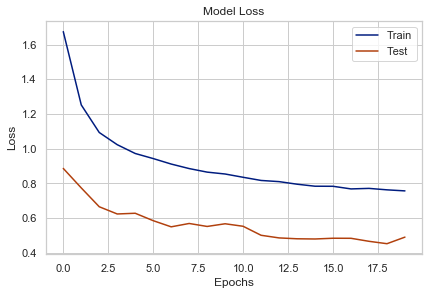

In [66]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'])
plt.show()

Test loss'muz 0.9181 dan baslayarak 0.4839 'a kadar azalıyor. Epoch sayısı arttıkca buda azalacagını görebiliyoruz.

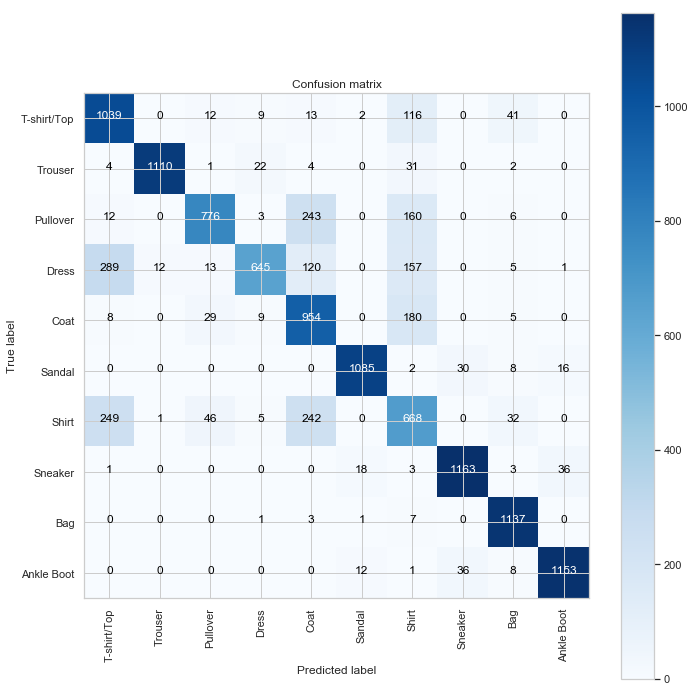

In [67]:
# Plot confusion matrix

import math 
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, 
            classes = ['T-shirt/Top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot'])

Comments: Confusion matrix ile en cok hatanın Coat'a Shirt dediğimizi görebiliriz. Yine Shirt image'ini T-shirt, Pullover, Dress  ve Coat ile yanlıs tahmin etmiş.

Shirt olan image'lerede yüksek oranda T-shirt ile hatalı classify ettigini görebiliriz. Pullover,da benzer sınıflandırma hataları mevcut.    

### g. Classification Report

The classification report visualizer displays the precision, recall, F1, and support scores for the model.

- **Precision:**

  “For all instances classified positive, what percent was correct?” <br/><br/>

- **Recall:**

  “For all instances that were actually positive, what percent was classified correctly?”


\begin{equation*}
Precision = \frac{TP}{(TP+FP)} \quad\quad 
Recall = \frac{TP}{(TP+FN)} \quad\quad 
Accuracy = \frac{TP+TN}{(TP+TN+FP+FN)}
\end{equation*}

In [68]:
classes = ['T-shirt/Top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot']
print(classification_report(Y_true, Y_pred_classes, target_names = classes))

              precision    recall  f1-score   support

 T-shirt/Top       0.65      0.84      0.73      1232
     Trouser       0.99      0.95      0.97      1174
    Pullover       0.88      0.65      0.75      1200
       Dress       0.93      0.52      0.67      1242
        Coat       0.60      0.81      0.69      1185
      Sandal       0.97      0.95      0.96      1141
       Shirt       0.50      0.54      0.52      1243
     Sneaker       0.95      0.95      0.95      1224
         Bag       0.91      0.99      0.95      1149
  Ankle Boot       0.96      0.95      0.95      1210

   micro avg       0.81      0.81      0.81     12000
   macro avg       0.83      0.81      0.81     12000
weighted avg       0.83      0.81      0.81     12000



Look at the Precision of the Shirts, we can see that our model predicted less than 80% of Shirts correctly out of the total images it predicted as Shirts. We did conclude the same from the confusion matrix, where we saw that a lot of T-shirts were misclassified as Shirts.

### h. Prediction on Test Data

In [69]:
score = model.evaluate(test, y_test)

print("Loss: {:.4f}".format(score[0]))
print("Accuracy: {:.4f}".format(score[1]))

10000/10000 [==============================] - 13s 1ms/step
Loss: 0.4652
Accuracy: 0.8245


# How could I increase the accuracy ?
- Adjust data augmentation values 
- Increase the number of epoch 
- Add new hidden layers with Dense
- Change filter size and kernel_size in the convolution layer.

# Re-train the Model 

In [22]:
# Building a ConvNet
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', strides=1, padding='same', 
                 data_format='channels_last', input_shape=(28,28,1)))
model.add(BatchNormalization())

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', strides=1, padding='same', 
                 data_format='channels_last'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', strides=1, padding='same', 
                 data_format='channels_last'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
    
    
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', strides=1, padding='same', 
                 data_format='channels_last'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

In [23]:
# Optimizer
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

In [24]:
# Compiling the model
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

In [25]:
# Augmentation
datagen = ImageDataGenerator(
        rotation_range = 4,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        shear_range = 0.3,# shear angle in counter-clockwise direction in degrees  
        width_shift_range=0.08,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.08,  # randomly shift images vertically (fraction of total height)
        vertical_flip=True)  # randomly flip images

datagen.fit(X_train)

In [26]:
# Fitting the Model
batch_size = 128
epochs = 40


# Fit the model
train_model = model.fit_generator(datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, 
                              validation_data = (X_val,y_val), 
                              verbose=2)

Instructions for updating:
Use tf.cast instead.
Epoch 1/40
 - 1104s - loss: 0.8387 - acc: 0.7006 - val_loss: 0.5436 - val_acc: 0.7865
Epoch 2/40
 - 3819s - loss: 0.5538 - acc: 0.7967 - val_loss: 0.3946 - val_acc: 0.8535
Epoch 3/40
 - 1123s - loss: 0.4732 - acc: 0.8286 - val_loss: 0.3532 - val_acc: 0.8697
Epoch 4/40
 - 4128s - loss: 0.4310 - acc: 0.8461 - val_loss: 0.3230 - val_acc: 0.8760
Epoch 5/40
 - 1089s - loss: 0.4056 - acc: 0.8540 - val_loss: 0.3063 - val_acc: 0.8884
Epoch 6/40
 - 1149s - loss: 0.3844 - acc: 0.8633 - val_loss: 0.2766 - val_acc: 0.8965
Epoch 7/40
 - 1221s - loss: 0.3733 - acc: 0.8655 - val_loss: 0.2922 - val_acc: 0.8891
Epoch 8/40
 - 1203s - loss: 0.3577 - acc: 0.8706 - val_loss: 0.2754 - val_acc: 0.8950
Epoch 9/40
 - 1399s - loss: 0.3460 - acc: 0.8753 - val_loss: 0.2777 - val_acc: 0.8939
Epoch 10/40
 - 1151s - loss: 0.3399 - acc: 0.8779 - val_loss: 0.2499 - val_acc: 0.9068
Epoch 11/40
 - 1109s - loss: 0.3303 - acc: 0.8822 - val_loss: 0.2375 - val_acc: 0.9127
Epoc

In [28]:
# Evaluation the Results
score = model.evaluate(X_val, y_val)

print('Loss: {:.4f}'.format(score[0]))
print('Accuracy: {:.4f}'.format(score[1]))

12000/12000 [==============================] - 67s 6ms/step
Loss: 0.2122
Accuracy: 0.9229


In [30]:
plot_accuracy_and_loss(train_model)

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]



After tunning the parameters, the validation accuracy and validation loss are much better.

In [32]:
# Now, evaluate the test prediction accuracy with the new model
score = model.evaluate(test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.19066306959688664
Test accuracy: 0.9308


Also, the test accuracy increased.

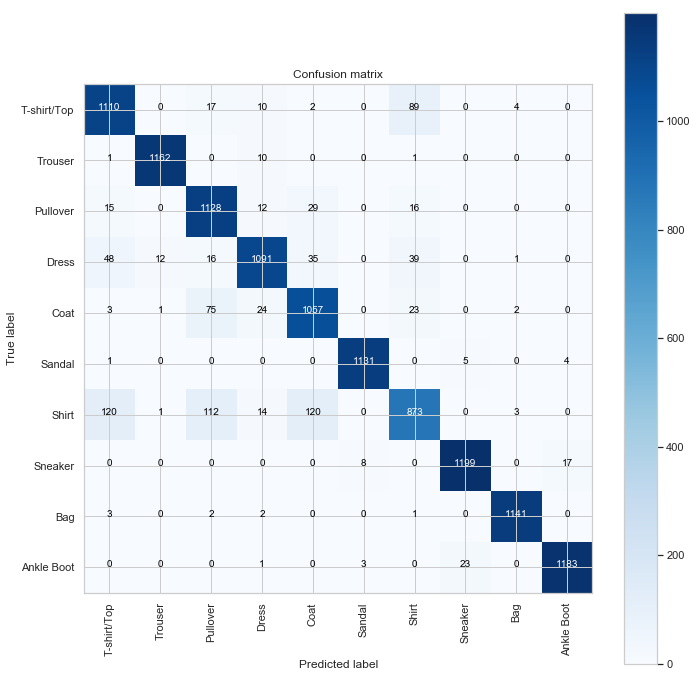

In [36]:
# Plot confusion matrix

import math 
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, 
            classes = ['T-shirt/Top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot'])

In [35]:
# Classification Report
classes = ['T-shirt/Top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot']
print(classification_report(Y_true, Y_pred_classes, target_names = classes))

              precision    recall  f1-score   support

 T-shirt/Top       0.85      0.90      0.88      1232
     Trouser       0.99      0.99      0.99      1174
    Pullover       0.84      0.94      0.88      1200
       Dress       0.94      0.88      0.91      1242
        Coat       0.85      0.89      0.87      1185
      Sandal       0.99      0.99      0.99      1141
       Shirt       0.84      0.70      0.76      1243
     Sneaker       0.98      0.98      0.98      1224
         Bag       0.99      0.99      0.99      1149
  Ankle Boot       0.98      0.98      0.98      1210

   micro avg       0.92      0.92      0.92     12000
   macro avg       0.92      0.92      0.92     12000
weighted avg       0.92      0.92      0.92     12000

